In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ucihar-dataset/UCI-HAR Dataset/activity_labels.txt
/kaggle/input/ucihar-dataset/UCI-HAR Dataset/README.txt
/kaggle/input/ucihar-dataset/UCI-HAR Dataset/features_info.txt
/kaggle/input/ucihar-dataset/UCI-HAR Dataset/features.txt
/kaggle/input/ucihar-dataset/UCI-HAR Dataset/test/subject_test.txt
/kaggle/input/ucihar-dataset/UCI-HAR Dataset/test/y_test.txt
/kaggle/input/ucihar-dataset/UCI-HAR Dataset/test/X_test.txt
/kaggle/input/ucihar-dataset/UCI-HAR Dataset/test/Inertial Signals/body_acc_y_test.txt
/kaggle/input/ucihar-dataset/UCI-HAR Dataset/test/Inertial Signals/total_acc_y_test.txt
/kaggle/input/ucihar-dataset/UCI-HAR Dataset/test/Inertial Signals/total_acc_z_test.txt
/kaggle/input/ucihar-dataset/UCI-HAR Dataset/test/Inertial Signals/body_acc_z_test.txt
/kaggle/input/ucihar-dataset/UCI-HAR Dataset/test/Inertial Signals/body_gyro_y_test.txt
/kaggle/input/ucihar-dataset/UCI-HAR Dataset/test/Inertial Signals/body_gyro_x_test.txt
/kaggle/input/ucihar-dataset/UCI-HAR Datase

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
from torchinfo import summary
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score

In [3]:
path = '/kaggle/input/ucihar-dataset/UCI-HAR Dataset'

In [5]:
# Test
X_test = np.loadtxt(f'{path}/test/X_test.txt')
y_test = np.loadtxt(f'{path}/test/y_test.txt')


## Modelling Processed Features

In [4]:
# Train
X_train = np.loadtxt(f'{path}/train/X_train.txt')
y_train = np.loadtxt(f'{path}/train/y_train.txt')

X_train.shape

(7352, 561)

In [5]:
y_train = y_train-1
y_train = y_train.astype(int)
y_train.shape

(7352,)

In [6]:
class_counts = np.bincount(y_train) 
activity_map = {
    0: "WALKING",
    1: "WALKING_UPSTAIRS",
    2: "WALKING_DOWNSTAIRS",
    3: "SITTING",
    4: "STANDING",
    5: "LAYING"
}

for i,activity in enumerate(activity_map.values()):
    print(f"{activity}: {class_counts[i]}")

WALKING: 1226
WALKING_UPSTAIRS: 1073
WALKING_DOWNSTAIRS: 986
SITTING: 1286
STANDING: 1374
LAYING: 1407


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


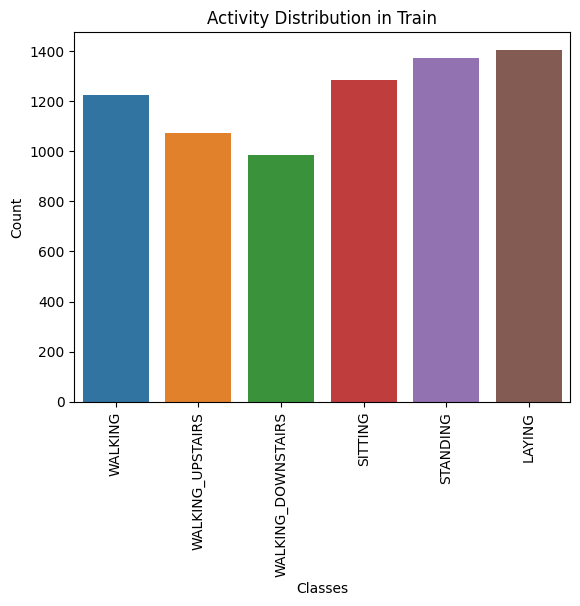

In [9]:

plt.title("Activity Distribution in Train")
sns.barplot(x=list(activity_map.values()),y = class_counts)
plt.xlabel("Classes")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.show()


In [10]:
class_samples = {}

for activity in np.unique(y_train):
    indices = np.where(y_train==activity)[0]
    random_index = np.random.choice(indices)
    class_samples[activity] = X_train[random_index]
    

### Visualizing Processed features

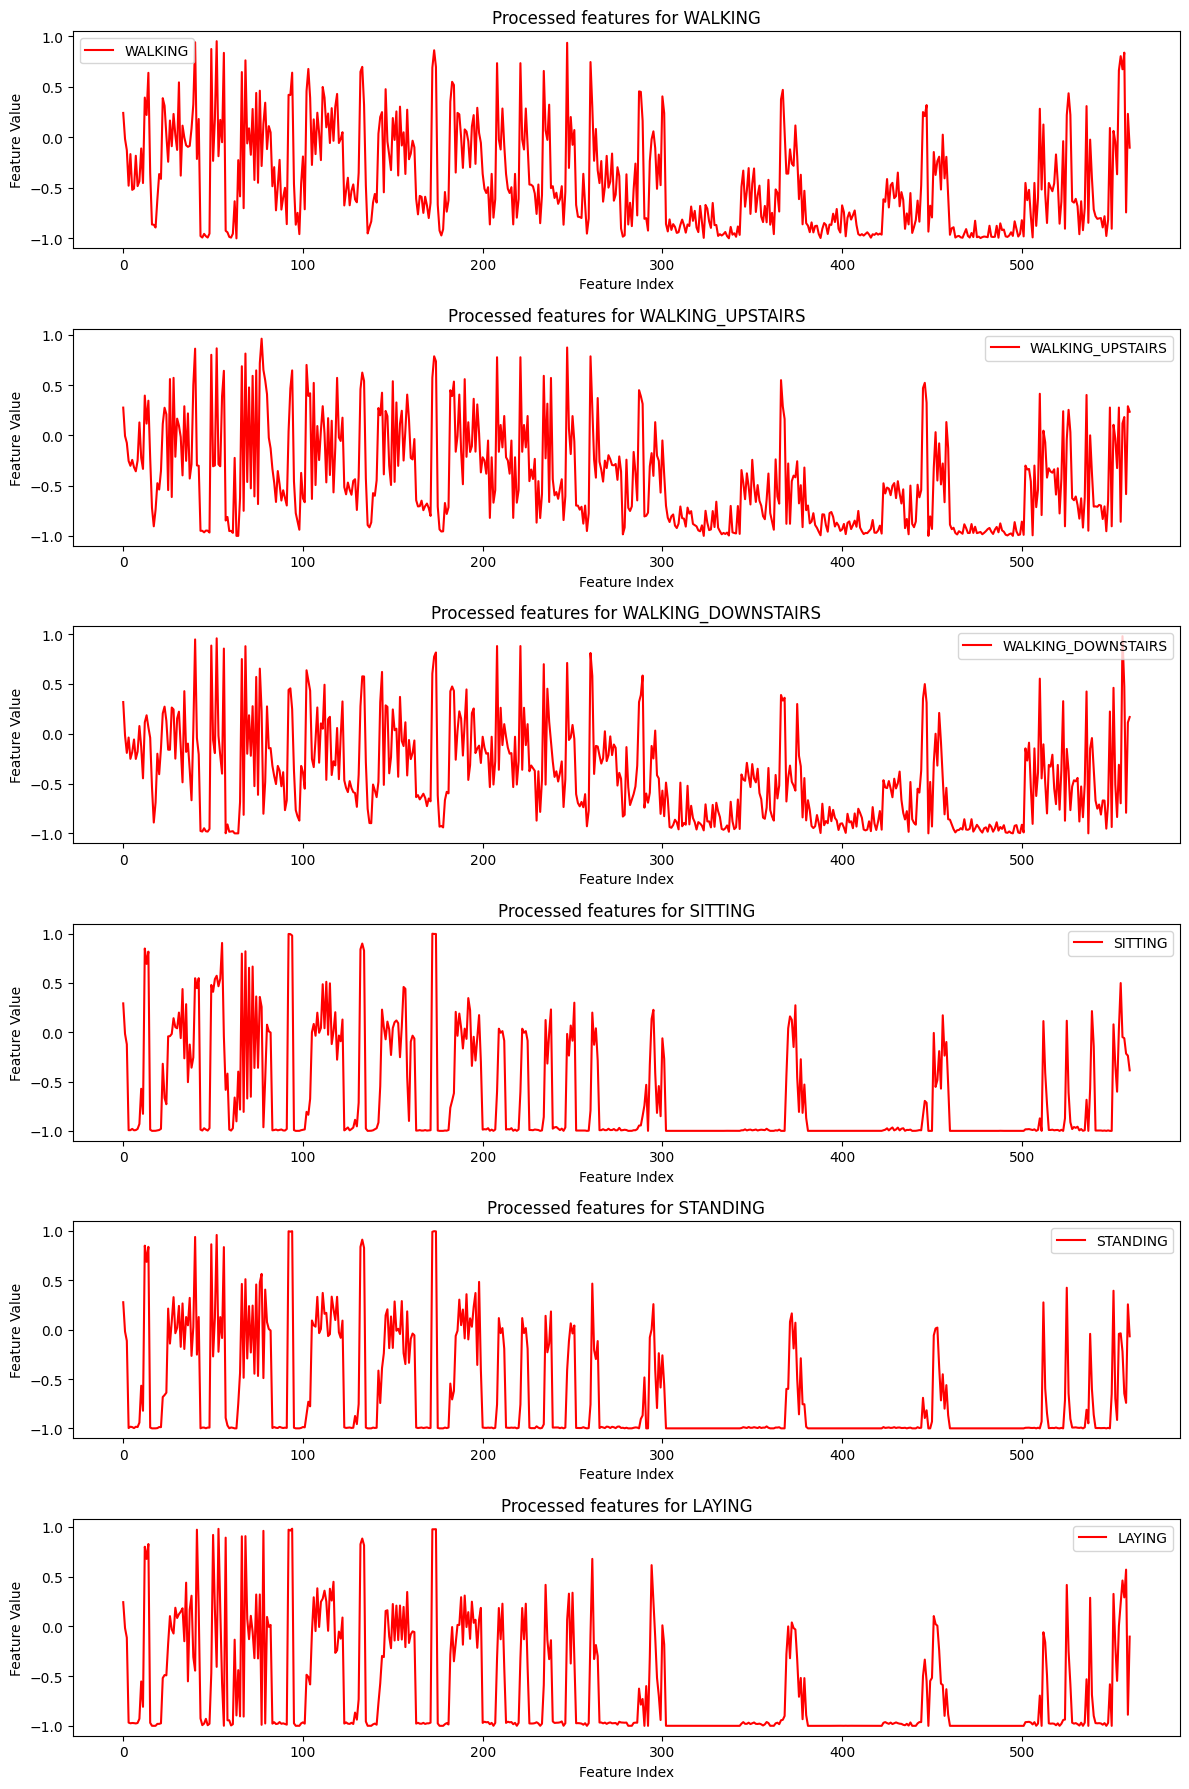

In [11]:
plt.figure(figsize = (12,18))

for i, (activity, features) in enumerate(class_samples.items(), start =1):
    plt.subplot(len(class_samples),1,i) 
    plt.plot(features, label=activity_map[activity], color="r")
    plt.title(f"Processed features for {activity_map[activity]}")
    plt.xlabel("Feature Index")
    plt.ylabel("Feature Value")
    plt.legend()

plt.tight_layout()
plt.show()

In [12]:
X_test = np.loadtxt(f'{path}/test/X_test.txt')
y_test = np.loadtxt(f'{path}/test/y_test.txt')

In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)

dataset = TensorDataset(X_train_tensor,y_train_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset,val_dataset = random_split(dataset,[train_size,val_size])

print(f'Total samples : {len(dataset)}')
print(f'Train samples: {len(train_dataset)}')
print(f'Test samples: {len(val_dataset)}')

Total samples : 7352
Train samples: 5881
Test samples: 1471


In [15]:
train_loader = DataLoader(train_dataset,batch_size=64,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=64,shuffle=False)

### FCN (Fully Connected Network)

In [22]:
class HAR_FCN(nn.Module):
    def __init__(self,input_size=561,drop_out=0.1,num_classes=6):
        super(HAR_FCN, self).__init__()
        self.fc1 = nn.Linear(input_size,256)
        self.bn1 = nn.BatchNorm1d(256)
        self.drop1 = nn.Dropout(drop_out)
        
        self.fc2 = nn.Linear(256,128)
        self.bn2 = nn.BatchNorm1d(128)
        self.drop2 = nn.Dropout(drop_out)
        
        self.fc3 = nn.Linear(128,num_classes)
        
        self.relu = nn.ReLU()


    def forward(self,x):
       x = self.fc1(x)
       x = self.bn1(x)
       x = self.relu(x)
       x = self.drop1(x)

       x = self.fc2(x)
       x = self.bn2(x)
       x = self.relu(x)
       x = self.drop2(x)

       x = self.fc3(x)


       return x

model = HAR_FCN(input_size = 561,drop_out = 0.1,num_classes=6)
summary(model)
        

Layer (type:depth-idx)                   Param #
HAR_FCN                                  --
├─Linear: 1-1                            143,872
├─BatchNorm1d: 1-2                       512
├─Dropout: 1-3                           --
├─Linear: 1-4                            32,896
├─BatchNorm1d: 1-5                       256
├─Dropout: 1-6                           --
├─Linear: 1-7                            774
├─ReLU: 1-8                              --
Total params: 178,310
Trainable params: 178,310
Non-trainable params: 0

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"using device:{device}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.01,weight_decay=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min', patience=5,factor=0.5)

using device:cuda


In [24]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    for batch_idx, (data, targets) in enumerate(dataloader):
        data, targets = data.to(device), targets.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == targets).sum().item()
        total_samples += targets.size(0)
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        for data, targets in dataloader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_predictions += (predicted == targets).sum().item()
            total_samples += targets.size(0)
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

In [25]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=100):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_val_acc = 0.0
    patience_counter = 0
    patience = 15  
    
    for epoch in range(epochs):
       
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
       
        scheduler.step(val_loss)
        
      
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
      
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_fcn_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        # Print progress
        if (epoch + 1) % 10 == 0 or epoch == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch [{epoch+1}/{epochs}]')
            print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
            print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
            print(f'  Best Val Acc: {best_val_acc:.4f}')
            print(f'  LR: {current_lr:.6f}')
            print('-' * 50)
    
    print(f"Training completed! Best validation accuracy: {best_val_acc:.4f}")
    return train_losses, train_accs, val_losses, val_accs

# Start training
train_losses, train_accs, val_losses, val_accs = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=100
)

Epoch [1/100]
  Train Loss: 0.3352, Train Acc: 0.8662
  Val Loss: 0.1164, Val Acc: 0.9565
  Best Val Acc: 0.9565
  LR: 0.010000
--------------------------------------------------
Epoch [10/100]
  Train Loss: 0.0809, Train Acc: 0.9708
  Val Loss: 0.1264, Val Acc: 0.9504
  Best Val Acc: 0.9728
  LR: 0.010000
--------------------------------------------------
Epoch [20/100]
  Train Loss: 0.0377, Train Acc: 0.9859
  Val Loss: 0.0834, Val Acc: 0.9708
  Best Val Acc: 0.9803
  LR: 0.005000
--------------------------------------------------
Epoch [30/100]
  Train Loss: 0.0472, Train Acc: 0.9828
  Val Loss: 0.0480, Val Acc: 0.9816
  Best Val Acc: 0.9857
  LR: 0.002500
--------------------------------------------------
Epoch [40/100]
  Train Loss: 0.0160, Train Acc: 0.9944
  Val Loss: 0.0437, Val Acc: 0.9878
  Best Val Acc: 0.9891
  LR: 0.001250
--------------------------------------------------
Epoch [50/100]
  Train Loss: 0.0111, Train Acc: 0.9966
  Val Loss: 0.0406, Val Acc: 0.9891
  Best Val

Final Validation Accuracy: 0.9891

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       245
           1       1.00      1.00      1.00       210
           2       1.00      1.00      1.00       182
           3       0.96      0.97      0.97       253
           4       0.98      0.97      0.97       300
           5       1.00      1.00      1.00       281

    accuracy                           0.99      1471
   macro avg       0.99      0.99      0.99      1471
weighted avg       0.99      0.99      0.99      1471



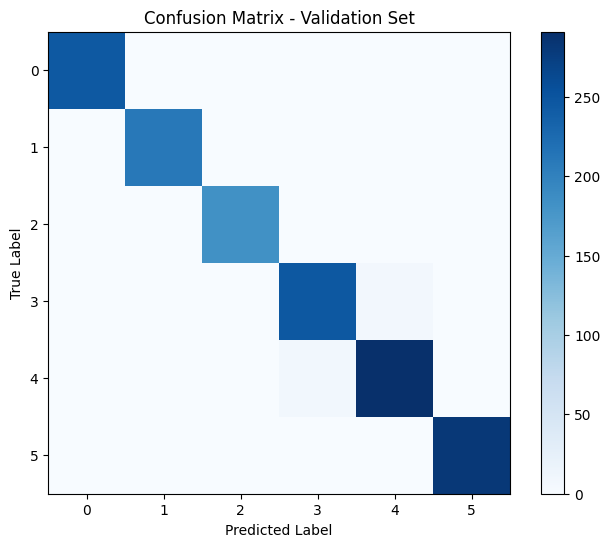

In [26]:
def evaluate_model(model, val_loader, device):
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, targets in val_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    accuracy = accuracy_score(all_targets, all_predictions)
    print(f"Final Validation Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_targets, all_predictions))
    
   
    cm = confusion_matrix(all_targets, all_predictions)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix - Validation Set')
    plt.colorbar()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    return accuracy


model.load_state_dict(torch.load('best_fcn_model.pth'))
final_accuracy = evaluate_model(model, val_loader, device)

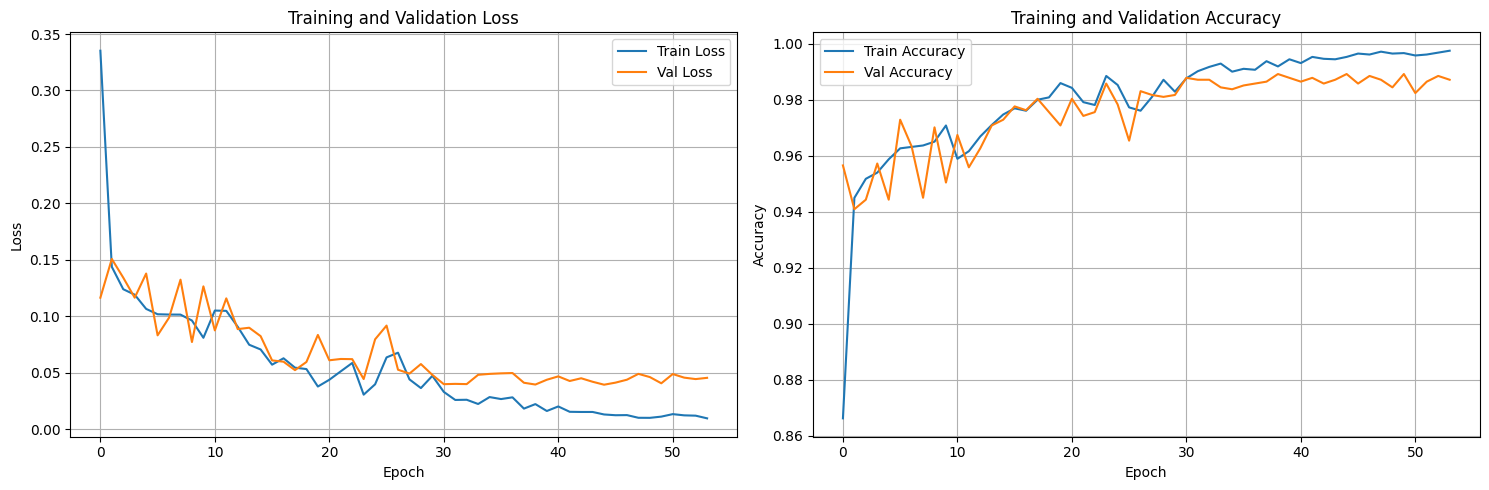

In [27]:
def plot_training_history(train_losses, train_accs, val_losses, val_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
 
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Val Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    
    ax2.plot(train_accs, label='Train Accuracy')
    ax2.plot(val_accs, label='Val Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(train_losses, train_accs, val_losses, val_accs)

Class distribution:
Original: [1226 1073  986 1286 1374 1407]
Train:    [ 981  863  804 1033 1074 1126]
Val:      [245 210 182 253 300 281]


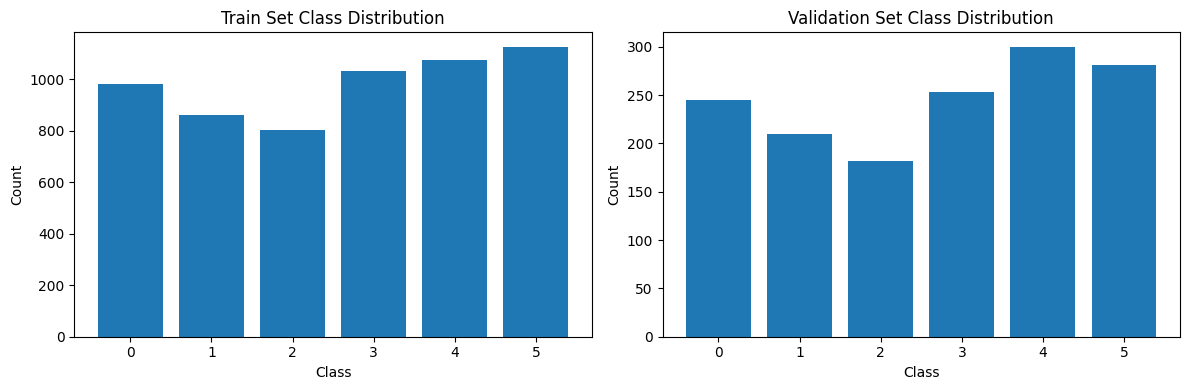

In [28]:

def check_class_distribution(train_dataset, val_dataset, original_labels):
    train_indices = train_dataset.indices
    val_indices = val_dataset.indices
    
    train_labels = original_labels[train_indices]
    val_labels = original_labels[val_indices]
    
    print("Class distribution:")
    print(f"Original: {np.bincount(original_labels)}")
    print(f"Train:    {np.bincount(train_labels)}")
    print(f"Val:      {np.bincount(val_labels)}")
    
    # Plot distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.bar(range(len(np.bincount(train_labels))), np.bincount(train_labels))
    ax1.set_title('Train Set Class Distribution')
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Count')
    
    ax2.bar(range(len(np.bincount(val_labels))), np.bincount(val_labels))
    ax2.set_title('Validation Set Class Distribution')
    ax2.set_xlabel('Class')
    ax2.set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()

check_class_distribution(train_dataset, val_dataset, y_train)

**FCN performs well with processed data with a good generalization; the data set is somewhat unbalanced, so we can't fully rely on accuracy, but FCN performs overall best with other metrics too.**

## Modelling Raw, Unprocessed Signals 

In [6]:
acc_x = np.loadtxt(f'{path}/train/Inertial Signals/body_acc_x_train.txt')
acc_y = np.loadtxt(f'{path}/train/Inertial Signals/body_acc_y_train.txt')
acc_z = np.loadtxt(f'{path}/train/Inertial Signals/body_acc_z_train.txt')
gyro_x = np.loadtxt(f'{path}/train/Inertial Signals/body_gyro_x_train.txt')
gyro_y = np.loadtxt(f'{path}/train/Inertial Signals/body_gyro_y_train.txt')
gyro_z = np.loadtxt(f'{path}/train/Inertial Signals/body_gyro_z_train.txt')

X_train_raw = np.stack([acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z],axis=2)

In [7]:
X_train_raw.shape

(7352, 128, 6)

In [9]:
def extract_class(X_train_raw,y_train, walking_class = 0):
    walking_info = np.where(y_train==walking_class)[0]
    walking_data = X_train_raw[walking_info]
    print(f"Found {len(walking_info)} walking samples")
    return walking_info,walking_data


walking_info,walking_data = extract_class(X_train_raw,y_train,walking_class = 0)


Found 1226 walking samples


### Visualizing Raw Signals

In [10]:
def plot_samples(walking_data,sample_idx=0):
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,10))
    sample = walking_data[sample_idx]
    time_steps = np.arange(128)

    ax1.plot(time_steps, sample[:, 0], label = 'x-axis', color='red', linewidth=1.5, alpha=0.8)
    ax1.plot(time_steps, sample[:, 1], label = 'y-axis', color='green', linewidth=1.5, alpha=0.8)
    ax1.plot(time_steps, sample[:, 2], label = 'z-axis', color='blue', linewidth=1.5, alpha=0.8)
    ax1.set_title('Accelerometer Signals for WALKING',fontsize=16, fontweight='bold',pad=20)
    ax1.set_ylabel('Acceleration (g)',fontsize=12)
    ax1.legend(loc='upper right', fontsize = 10)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 127)

    ax2.plot(time_steps, sample[:, 3], label = 'x-axis', color='red', linewidth=1.5,alpha=0.8)
    ax2.plot(time_steps, sample[:, 4], label = 'y-axis', color='green', linewidth=1.5,alpha=0.8)
    ax2.plot(time_steps, sample[:, 5], label = 'z-axis', color='blue', linewidth=1.5,alpha=0.8)
    ax2.set_title('Gyroscope Signals for WALKING', fontsize=16, fontweight='bold',pad=20)
    ax2.set_ylabel('Angular velocity', fontsize=12)
    ax2.legend(loc='upper right', fontsize=10)
    ax2.grid(True,alpha=0.3)
    ax2.set_xlim(0,127)

    plt.tight_layout()
    plt.show()
    

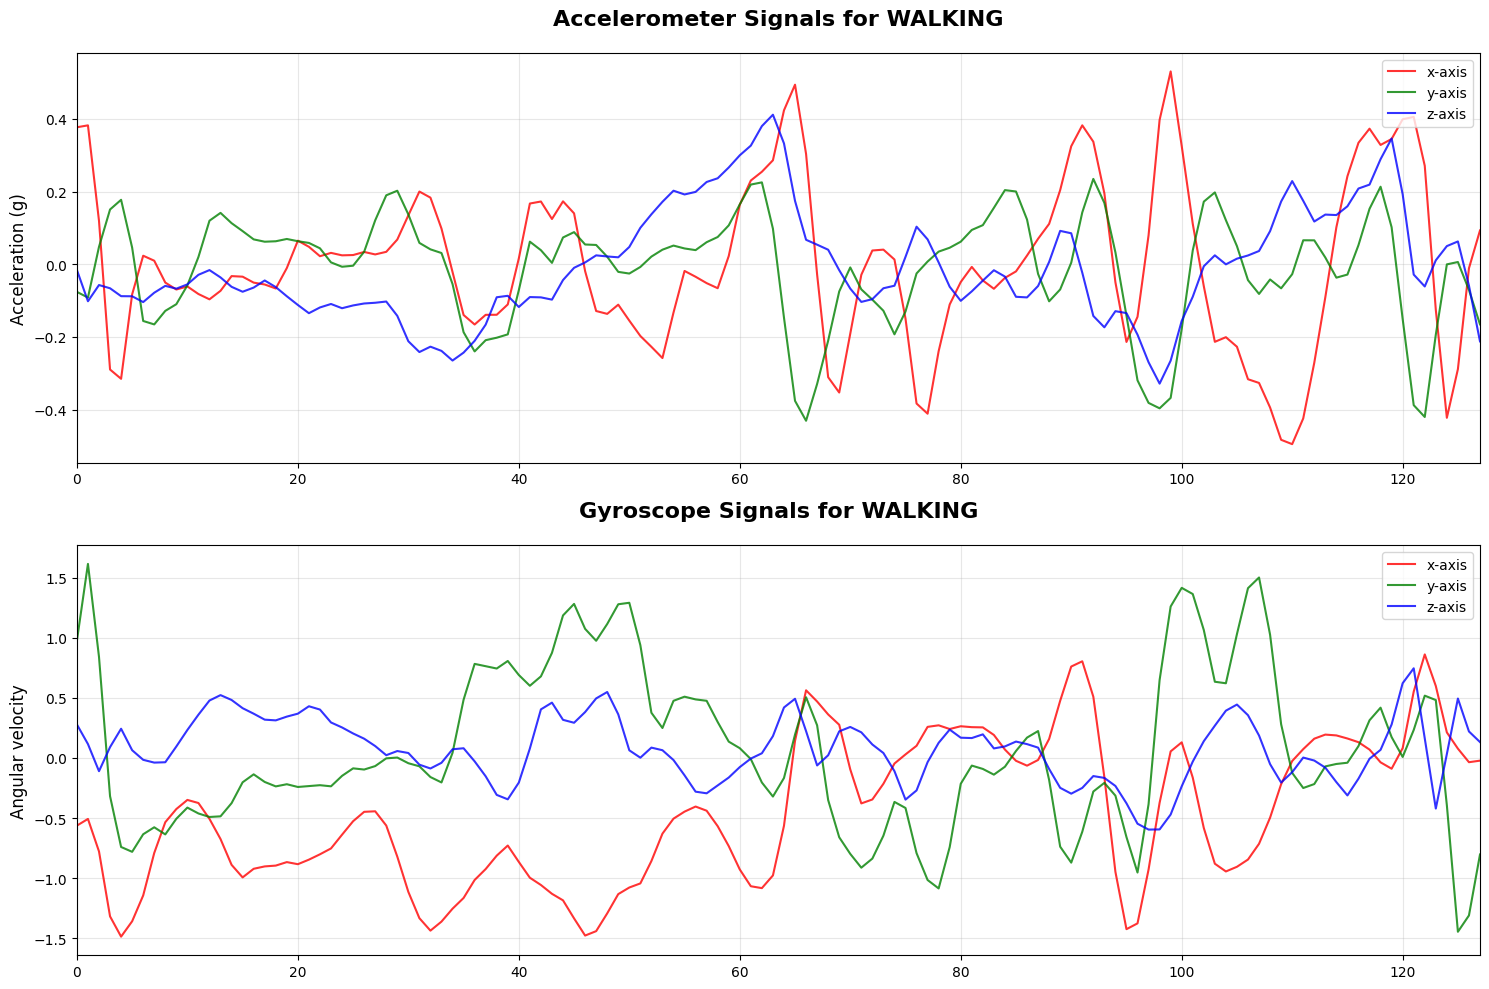

In [11]:
plot_samples(walking_data,sample_idx=0)

In [8]:
X_train_raw_tensor = torch.FloatTensor(X_train_raw)
y_train_tensor = torch.LongTensor(y_train)

dataset = TensorDataset(X_train_raw_tensor,y_train_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset,val_dataset = random_split(dataset,[train_size,val_size])

print(f'Total samples : {len(dataset)}')
print(f'Train samples: {len(train_dataset)}')
print(f'Test samples: {len(val_dataset)}')

Total samples : 7352
Train samples: 5881
Test samples: 1471


In [9]:
train_loader = DataLoader(train_dataset,batch_size=64,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=64,shuffle=False)

### Implementing Attention 

In [45]:
class Attention(nn.Module):
    def __init__(self,hidden_size,bidirectional=True):
        super(Attention,self).__init__()
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.factor = 2

        self.attention_weights = nn.Linear(self.hidden_size * self.factor, 1)


    def forward(self, lstm_output):
         attention_scores = self.attention_weights(lstm_output).squeeze(-1)
         attention_weights = torch.softmax(attention_scores, dim=-1)

         context_vector = torch.bmm(attention_weights.unsqueeze(1), lstm_output)
         context_vector = context_vector.squeeze(1)

         return context_vector, attention_weights

### biLSTM + Attention

In [47]:
class AdaptivebiLSTM(nn.Module):
    def __init__(self, input_size=6, hidden_size = 128, num_layers = 2, num_classes =6,bidirectional=True):
        super(AdaptivebiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_direction = 2

        self.lstm = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True,
            bidirectional = bidirectional
        )

        self.bn1 = nn.BatchNorm1d(hidden_size * self.num_direction)

        self.attention = Attention(hidden_size, bidirectional)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * self.num_direction, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128,num_classes)
        )

    def forward(self,x, return_attention=False):
          batch_size, sequence_length, input_size = x.size()
          lstm_out, (hidden, cell) = self.lstm(x)

          lstm_out_reshaped = lstm_out.contiguous().view(-1,self.hidden_size * self.num_direction)
          lstm_out_norm = self.bn1(lstm_out_reshaped)
          lstm_out = lstm_out_norm.view(batch_size, sequence_length, self.hidden_size * self.num_direction)

          context_vector, attention_weights = self.attention(lstm_out)

          output = self.classifier(context_vector)
          return output

In [48]:
model = AdaptivebiLSTM(input_size = 6, hidden_size = 128, num_layers = 2, num_classes = 6,bidirectional=True)
summary(model)

Layer (type:depth-idx)                   Param #
AdaptivebiLSTM                           --
├─LSTM: 1-1                              534,528
├─BatchNorm1d: 1-2                       512
├─Attention: 1-3                         --
│    └─Linear: 2-1                       257
├─Sequential: 1-4                        --
│    └─Linear: 2-2                       32,896
│    └─BatchNorm1d: 2-3                  256
│    └─ReLU: 2-4                         --
│    └─Dropout: 2-5                      --
│    └─Linear: 2-6                       774
Total params: 569,223
Trainable params: 569,223
Non-trainable params: 0

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"using device:{device}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min', patience=5,factor=0.5)

using device:cuda


In [50]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, device):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': [],
            'learning_rates': []
        }
        
    def train_epoch(self, criterion, optimizer):
        """Train for one epoch"""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(self.train_loader, desc='Training')
        for batch_idx, (data, targets) in enumerate(pbar):
            data, targets = data.to(self.device), targets.to(self.device)
            
            optimizer.zero_grad()
            outputs = self.model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            
            # Gradient clipping for LSTM
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
        
        epoch_loss = running_loss / len(self.train_loader)
        epoch_acc = 100. * correct / total
        
        return epoch_loss, epoch_acc
    
    def validate_epoch(self, criterion):
        """Validate for one epoch"""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_targets = []
        all_predictions = []
        
        with torch.no_grad():
            for data, targets in self.val_loader:
                data, targets = data.to(self.device), targets.to(self.device)
                outputs = self.model(data)
                loss = criterion(outputs, targets)
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
                
                all_targets.extend(targets.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
        
        epoch_loss = running_loss / len(self.val_loader)
        epoch_acc = 100. * correct / total
        
        return epoch_loss, epoch_acc, all_targets, all_predictions
    
    def train(self, epochs=100, patience=15, lr=0.001):
        """Complete training loop"""
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', patience=5, factor=0.5, verbose=True
        )
        
        best_val_acc = 0.0
        patience_counter = 0
        
        
        print(f"Starting training for {epochs} epochs...")
        print(f"Training on: {self.device}")
        print("-" * 60)
        
        for epoch in range(epochs):
           
            
            train_loss, train_acc = self.train_epoch(criterion, optimizer)
            
         
            val_loss, val_acc, val_targets, val_predictions = self.validate_epoch(criterion)
            
           
            scheduler.step(val_loss)
            current_lr = optimizer.param_groups[0]['lr']
            
            
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['learning_rates'].append(current_lr)
            
            #epoch_time = time.time() - epoch_start
            
            
            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f'Epoch {epoch+1:03d}/{epochs}')
                print(f'  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
                print(f'  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
                print(f'  LR: {current_lr:.6f}')
                print('-' * 50)
            
           
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_acc': val_acc,
                    'val_loss': val_loss,
                }, 'best_bilstm_attention_model.pth')
                patience_counter = 0
                print(f'↳ New best model saved! Val Acc: {val_acc:.2f}%')
            else:
                patience_counter += 1
            
            # Early stopping
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
        
        
       
        print(f"Best validation accuracy: {best_val_acc:.2f}%")
        
        return self.history

In [31]:
def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
  
    ax1.plot(history['train_loss'], label='Training Loss', linewidth=2)
    ax1.plot(history['val_loss'], label='Validation Loss', linewidth=2)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    
    ax2.plot(history['train_acc'], label='Training Accuracy', linewidth=2)
    ax2.plot(history['val_acc'], label='Validation Accuracy', linewidth=2)
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    
    ax3.plot(history['learning_rates'], color='purple', linewidth=2)
    ax3.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.set_yscale('log')
    ax3.grid(True, alpha=0.3)
    
  
    ax4.scatter(history['train_loss'], history['train_acc'], alpha=0.6, 
                label='Training', s=20)
    ax4.scatter(history['val_loss'], history['val_acc'], alpha=0.6, 
                label='Validation', s=20)
    ax4.set_title('Loss vs Accuracy', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Loss')
    ax4.set_ylabel('Accuracy (%)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
   
    print("Final Metrics:")
    print(f"  Training Loss: {history['train_loss'][-1]:.4f}")
    print(f"  Training Accuracy: {history['train_acc'][-1]:.2f}%")
    print(f"  Validation Loss: {history['val_loss'][-1]:.4f}")
    print(f"  Validation Accuracy: {history['val_acc'][-1]:.2f}%")

In [32]:
def plot_confusion_matrix(model, data_loader, device, class_names=None):
    """Plot confusion matrix and classification report"""
    if class_names is None:
        class_names = ['Walking', 'Walking Upstairs', 'Walking Downstairs', 
                      'Sitting', 'Standing', 'Laying']
    
    model.eval()
    all_targets = []
    all_predictions = []
    all_probabilities = []
    
    with torch.no_grad():
        for data, targets in data_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
   
    all_targets = np.array(all_targets)
    all_predictions = np.array(all_predictions)
    all_probabilities = np.array(all_probabilities)
    
 
    accuracy = accuracy_score(all_targets, all_predictions)
    cm = confusion_matrix(all_targets, all_predictions)
    
   
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
   
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, ax=ax1)
    ax1.set_title(f'Confusion Matrix\nAccuracy: {accuracy:.4f}', 
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('Predicted Label')
    ax1.set_ylabel('True Label')
    
    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax2)
    ax2.set_title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Predicted Label')
    ax2.set_ylabel('True Label')
    
    plt.tight_layout()
    plt.show()
    
    
    print("\n" + "="*60)
    print("CLASSIFICATION REPORT")
    print("="*60)
    print(classification_report(all_targets, all_predictions, 
                                target_names=class_names, digits=4))
    
   
    print("\nPER-CLASS ACCURACY:")
    print("-" * 40)
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    for i, class_name in enumerate(class_names):
        print(f"{class_name:15}: {class_accuracy[i]:.4f}")
    
    return all_targets, all_predictions, all_probabilities

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting training for 50 epochs...
Training on: cuda
------------------------------------------------------------


Training: 100%|██████████| 92/92 [00:01<00:00, 52.98it/s, Loss=0.3465, Acc=82.74%]


Epoch 001/50
  Train Loss: 0.4081 | Train Acc: 82.74%
  Val Loss: 0.3718 | Val Acc: 83.89%
  LR: 0.001000
--------------------------------------------------
↳ New best model saved! Val Acc: 83.89%


Training: 100%|██████████| 92/92 [00:01<00:00, 54.88it/s, Loss=0.2409, Acc=85.24%]


↳ New best model saved! Val Acc: 85.86%


Training: 100%|██████████| 92/92 [00:01<00:00, 53.80it/s, Loss=0.4241, Acc=85.89%]


Epoch 005/50
  Train Loss: 0.3527 | Train Acc: 85.89%
  Val Loss: 0.3515 | Val Acc: 84.16%
  LR: 0.001000
--------------------------------------------------


Training: 100%|██████████| 92/92 [00:01<00:00, 53.73it/s, Loss=0.2407, Acc=86.55%]


↳ New best model saved! Val Acc: 86.06%


Training: 100%|██████████| 92/92 [00:01<00:00, 54.01it/s, Loss=0.2836, Acc=87.33%]


Epoch 010/50
  Train Loss: 0.3182 | Train Acc: 87.33%
  Val Loss: 0.3609 | Val Acc: 84.36%
  LR: 0.001000
--------------------------------------------------


Training: 100%|██████████| 92/92 [00:01<00:00, 54.93it/s, Loss=0.4616, Acc=88.61%]


↳ New best model saved! Val Acc: 88.04%


Training: 100%|██████████| 92/92 [00:01<00:00, 55.74it/s, Loss=0.1633, Acc=88.32%]


↳ New best model saved! Val Acc: 89.33%


Training: 100%|██████████| 92/92 [00:01<00:00, 55.97it/s, Loss=0.2087, Acc=88.45%]


Epoch 015/50
  Train Loss: 0.2726 | Train Acc: 88.45%
  Val Loss: 0.2789 | Val Acc: 87.63%
  LR: 0.001000
--------------------------------------------------


Training: 100%|██████████| 92/92 [00:01<00:00, 57.11it/s, Loss=0.2196, Acc=88.52%]


Epoch 020/50
  Train Loss: 0.2757 | Train Acc: 88.52%
  Val Loss: 0.2530 | Val Acc: 89.67%
  LR: 0.000500
--------------------------------------------------
↳ New best model saved! Val Acc: 89.67%


Training: 100%|██████████| 92/92 [00:01<00:00, 57.20it/s, Loss=0.2451, Acc=91.94%]


↳ New best model saved! Val Acc: 90.21%


Training: 100%|██████████| 92/92 [00:01<00:00, 57.47it/s, Loss=0.2957, Acc=91.87%]


↳ New best model saved! Val Acc: 91.16%


Training: 100%|██████████| 92/92 [00:01<00:00, 57.54it/s, Loss=0.1233, Acc=92.42%]


Epoch 025/50
  Train Loss: 0.2040 | Train Acc: 92.42%
  Val Loss: 0.2122 | Val Acc: 91.16%
  LR: 0.000500
--------------------------------------------------


Training: 100%|██████████| 92/92 [00:01<00:00, 57.78it/s, Loss=0.2148, Acc=92.67%]


Epoch 030/50
  Train Loss: 0.1866 | Train Acc: 92.67%
  Val Loss: 0.1985 | Val Acc: 91.50%
  LR: 0.000500
--------------------------------------------------
↳ New best model saved! Val Acc: 91.50%


Training: 100%|██████████| 92/92 [00:01<00:00, 57.61it/s, Loss=0.0793, Acc=92.62%]


Epoch 035/50
  Train Loss: 0.1934 | Train Acc: 92.62%
  Val Loss: 0.2040 | Val Acc: 91.57%
  LR: 0.000500
--------------------------------------------------
↳ New best model saved! Val Acc: 91.57%


Training: 100%|██████████| 92/92 [00:01<00:00, 57.57it/s, Loss=0.1430, Acc=93.35%]


↳ New best model saved! Val Acc: 92.11%


Training: 100%|██████████| 92/92 [00:01<00:00, 57.38it/s, Loss=0.1770, Acc=94.25%]


↳ New best model saved! Val Acc: 92.93%


Training: 100%|██████████| 92/92 [00:01<00:00, 57.61it/s, Loss=0.0742, Acc=94.12%]


Epoch 040/50
  Train Loss: 0.1551 | Train Acc: 94.12%
  Val Loss: 0.1801 | Val Acc: 92.73%
  LR: 0.000250
--------------------------------------------------


Training: 100%|██████████| 92/92 [00:01<00:00, 57.06it/s, Loss=0.1902, Acc=94.52%]


Epoch 045/50
  Train Loss: 0.1453 | Train Acc: 94.52%
  Val Loss: 0.1779 | Val Acc: 93.00%
  LR: 0.000250
--------------------------------------------------
↳ New best model saved! Val Acc: 93.00%


Training: 100%|██████████| 92/92 [00:01<00:00, 56.74it/s, Loss=0.1728, Acc=94.39%]


Epoch 050/50
  Train Loss: 0.1484 | Train Acc: 94.39%
  Val Loss: 0.2033 | Val Acc: 91.98%
  LR: 0.000250
--------------------------------------------------
Best validation accuracy: 93.00%


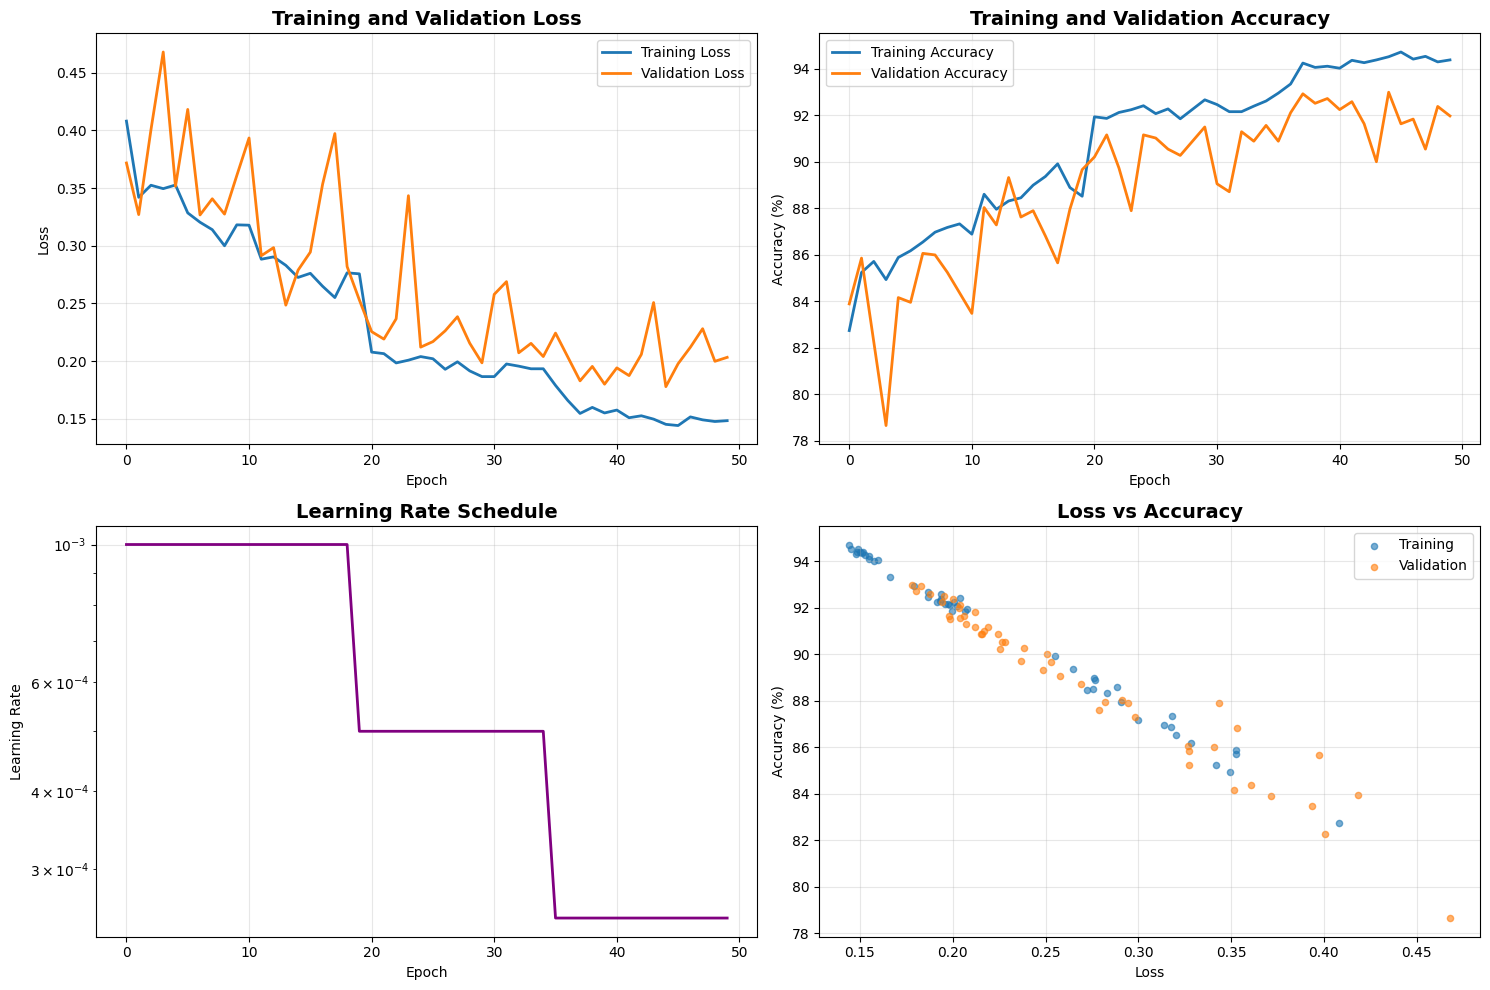

Final Metrics:
  Training Loss: 0.1484
  Training Accuracy: 94.39%
  Validation Loss: 0.2033
  Validation Accuracy: 91.98%


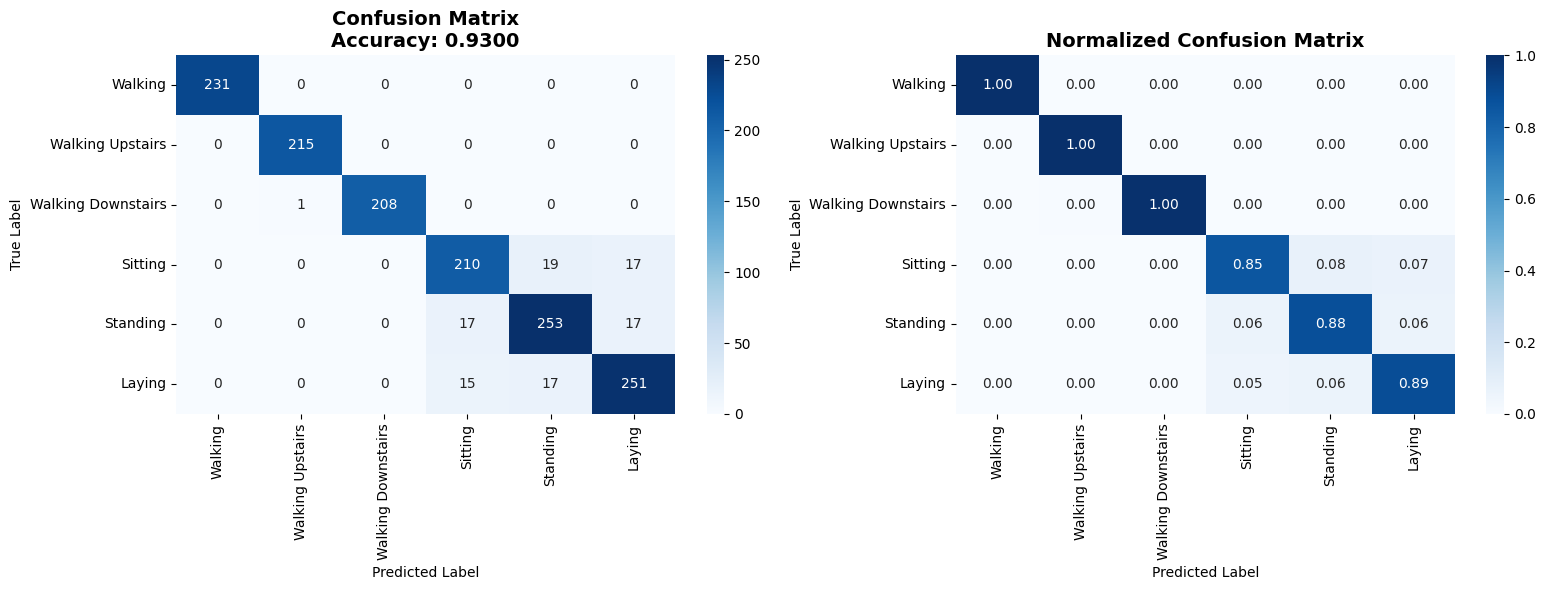


CLASSIFICATION REPORT
                    precision    recall  f1-score   support

           Walking     1.0000    1.0000    1.0000       231
  Walking Upstairs     0.9954    1.0000    0.9977       215
Walking Downstairs     1.0000    0.9952    0.9976       209
           Sitting     0.8678    0.8537    0.8607       246
          Standing     0.8754    0.8815    0.8785       287
            Laying     0.8807    0.8869    0.8838       283

          accuracy                         0.9300      1471
         macro avg     0.9365    0.9362    0.9364      1471
      weighted avg     0.9300    0.9300    0.9300      1471


PER-CLASS ACCURACY:
----------------------------------------
Walking        : 1.0000
Walking Upstairs: 1.0000
Walking Downstairs: 0.9952
Sitting        : 0.8537
Standing       : 0.8815
Laying         : 0.8869


In [52]:

def train_and_evaluate(model, train_loader, val_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    
    trainer = Trainer(model, train_loader, val_loader, device)
    history = trainer.train(epochs=50, patience=10, lr=0.001)
    
    
    plot_training_history(history)
    
  
    checkpoint = torch.load('best_bilstm_attention_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    
    plot_confusion_matrix(model, val_loader, device)
    
    return history, model


history, trained_model = train_and_evaluate(model, train_loader, val_loader)

**This evaluation suggests that the model is effective for classifying human activities from accelerometer and gyroscope data (raw and unprocessed)**
